# Effect of model scale on performance (Section 3.1)

Plot the performance of models of varying pretraining compute.

In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
palette = sns.color_palette("colorblind")
import matplotlib.pyplot as plt

from utils import load_responses, responses_to_counts
from utils import majority_trials, compute_case_acc

models = {
    'pythia-70m': 'Pythia 70M',
    'pythia-160m': 'Pythia 160M',
    'pythia-410m': 'Pythia 410M',
    'pythia-1b': 'Pythia 1B',
    'pythia-2.8b': 'Pythia 2.8B',
    'pythia-6.9b': 'Pythia 6.9B',
    'llama-2-7b': 'Llama 2 7B',
    'llama-3-8b': 'Llama 3 8B',
}

compute = {
    'pythia-70m': 0.07 * 0.3,
    'pythia-160m': 0.16 * 0.3,
    'pythia-410m': 0.41 * 0.3,
    'pythia-1b': 1. * 0.3,
    'pythia-2.8b': 2.8 * 0.3,
    'pythia-6.9b': 6.9 * 0.3,
    'llama-2-7b': 7 * 2,
    'llama-3-8b': 8 * 15,
    'llama-3-70b': 70 * 15,
}

In [2]:
responses = load_responses({}, models, 'results/scaling-experiments/')
responses = load_responses(responses, ['gpt4', 'lawma-8b', 'lawma-70b'], base_dir='results/model_responses/')
responses['llama-3-70b'] = responses['lawma-70b']  # lawma 70b is trained for one epoch
models['llama-3-70b'] = 'Llama 3 70B'

  0%|          | 0/258 [00:00<?, ?it/s]

100%|██████████| 258/258 [00:00<00:00, 1194.92it/s]


pythia-70m has 258 tasks


100%|██████████| 258/258 [00:00<00:00, 2371.24it/s]


pythia-160m has 258 tasks


100%|██████████| 258/258 [00:00<00:00, 1141.67it/s]


pythia-410m has 258 tasks


100%|██████████| 258/258 [00:00<00:00, 4083.11it/s]


pythia-1b has 258 tasks


100%|██████████| 258/258 [00:00<00:00, 4669.08it/s]


pythia-2.8b has 258 tasks


100%|██████████| 258/258 [00:00<00:00, 1324.12it/s]


pythia-6.9b has 258 tasks


100%|██████████| 260/260 [00:00<00:00, 3503.24it/s]


llama-2-7b has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 224.76it/s]


llama-3-8b has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 3956.47it/s]


gpt4 has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 253.57it/s]


lawma-8b has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 252.18it/s]

lawma-70b has 260 tasks


In [3]:
trials = {}
for model, model_responses in responses.items():
    trials[model] = {}
    for file, response in tqdm(model_responses.items()):
        trials[model][file] = responses_to_counts(response, gpt4=model=='gpt4')
trials['maj'] = {k: majority_trials(v) for k, v in list(responses.values())[0].items()}

# consider only those tasks for which we have all models
tasks = set(trials['maj'].keys())
for model in trials.keys():
    tasks = tasks.intersection(set(trials[model].keys()))

for model in trials.keys():
    trials[model] = {k: v for k, v in trials[model].items() if k in tasks}

100%|██████████| 260/260 [00:00<00:00, 1569.75it/s]


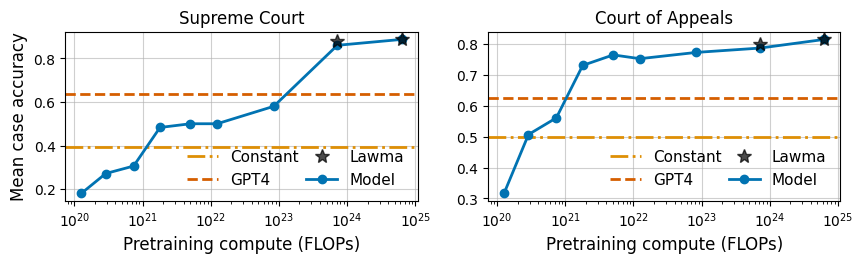

In [6]:
get_compute = lambda model: compute[model] * 1e21 * 6

prefixes = {
    'sc_': 'Supreme Court',
    'songer_': 'Court of Appeals',
}

def error_bar_transform(bars):
    min_ = [bar[0] for bar in bars]
    max_ = [bar[1] for bar in bars]
    return np.c_[min_, max_].T

fig, axs = plt.subplots(1, 2, figsize=(10, 2.2), dpi=100, sharey=False, sharex=True)

for (prefix, title), ax in zip(prefixes.items(), axs):     
    gpt4_acc, _ = compute_case_acc(trials['gpt4'], prefix=prefix)
    maj_acc, _ = compute_case_acc(trials['maj'], prefix=prefix)
    ax.axhline(y=maj_acc, color=palette[1], linestyle='-.', linewidth=2, label='Constant')
    ax.axhline(y=gpt4_acc, color=palette[3], linestyle='--', linewidth=2, label='GPT4')
   
    y_axis = [compute_case_acc(trials[model], prefix=prefix) for model in compute.keys()]
    y_axis = [y[0] for y in y_axis]
    x_axis = [get_compute(model) for model in compute.keys()]
    ax.errorbar(x_axis, y_axis, fmt='o-', color=palette[0], linewidth=2, label='Model')

    # stars - lawma models
    compute_models = ['llama-3-8b', 'llama-3-70b']
    star_models = ['lawma-8b', 'lawma-70b']
    x_axis = [get_compute(model) for model in compute_models]
    y_axis = [compute_case_acc(trials[model], prefix=prefix)[0] for model in star_models]
    ax.plot(x_axis, y_axis, '*', color='k', linewidth=2, label='Lawma', markersize=10, alpha=0.7, zorder=10)
    
    ax.set_xscale('log')
    ax.set_title(title, fontsize=12)
    ax.grid(True,  alpha=0.6)

    ax.legend(loc='lower right', ncol=2, fontsize=11, frameon=False, columnspacing=0.5)


for i in range(0, len(prefixes)):
    axs[i].set_xlabel('Pretraining compute (FLOPs)', fontsize=12)
axs[0].set_ylabel('Mean case accuracy', fontsize=12)

fig.subplots_adjust(wspace=0.2)
plt.savefig('plots/ft_scaling.pdf', bbox_inches='tight')

In [7]:
models = ['llama-3-8b', 'llama-3-70b']
print('Diff in perf:', compute_case_acc(trials[models[1]], prefix='sc_')[0] - compute_case_acc(trials[models[0]], prefix='sc_')[0])
print('Computes', get_compute(models[0]), get_compute(models[1]))

models = ['pythia-1b', 'llama-3-70b']
print('Diff in perf:', compute_case_acc(trials[models[1]], prefix='songer_')[0] - compute_case_acc(trials[models[0]], prefix='songer_')[0])
print('Computes', get_compute(models[0]), get_compute(models[1]))

Diff in perf: 0.027022537239049682
Computes 7.2e+23 6.3e+24
Diff in perf: 0.08390247799627515
Computes 1.8e+21 6.3e+24
